<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Stock_Market_Predictions_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Predict stock prices using Long Short Term Memory (LSTM) model.  

In [ ]:
# Install yfinance and cartopy packages.
!pip install yfinance
!pip install cartopy

In [2]:
# Import software libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Access and store the stock data.  
# We will use the Yahoo! Finance Market Downloader to get the data for Nvidia stock.
import yfinance as yf
company = yf.download('NVDA',start='2017-01-01',  end='2021-12-07',progress=False)[['Open', 'High', 'Low', 'Close', 'Volume']]

In [21]:
# Print the first 5 rows
company.head() 

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,26.1000,26.592501,24.844999,25.502501,150199600
2017-01-04,25.8500,26.375000,25.382500,26.097500,119922000
2017-01-05,26.1325,26.455000,25.262501,25.434999,98429600
2017-01-06,25.7125,26.062500,25.299999,25.775000,82285600
2017-01-09,25.8750,27.000000,25.875000,26.820000,91624800


This dataset was obtained from Yahoo Finance and includes 5 years of stock data for Nvidia corporation. Nvidia designs graphics processing units for the gaming and professional markets, as well as system on a chip units for the mobile computing and automotive market. 

The columns and definitions are described below. 

1. Date - in format: yyyy-mm-dd.

2. Open - price of the stock at market open (in US Dollars).

3. High - highest price reached in the day.

4. Low - lowest price reached in the day.

5. Close - closing price for the day.

6. Volume - number of shares traded for the day.


**Data Analysis and Exploration**

In [5]:
# Show information about the data columns.
company.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990 entries, 2018-01-02 to 2021-12-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    990 non-null    float64
 1   High    990 non-null    float64
 2   Low     990 non-null    float64
 3   Close   990 non-null    float64
 4   Volume  990 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 46.4 KB


There are 990 stock records and 5 columns. All the features have numeric data types. There are no null or missing values in the data set.  

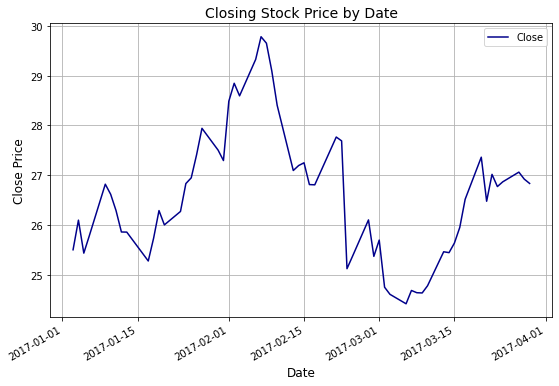

In [38]:
# Visualize the closing stock price by date for the first 60 days. 
# Extract only the top 60 rows. 
company_60 = company.head(60)
company_60.reset_index(inplace=True)
 
#  Plot closing stock price by date.
plt.rcParams['figure.figsize'] = [9, 6]
 
company_60.plot('Date','Close', color="darkblue")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.title('Closing Stock Price by Date', fontsize=14)
plt.grid()
plt.show()

...  

In [22]:
# Create a data set with only closing prices.
close_data = company['Close']
 
# Convert close data into an array.
close_array = close_data.values.reshape(-1, 1)

Normalize the feature dataset. We will use MinMax Scaler to transform the data so that its distribution will have a mean value of 0 and standard deviation of 1. 

In [23]:
# Normalize the close data.  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_array)

In [24]:
# Create the training data set which will include 70% of the total data.
training_data_len = math.ceil(len(close_array) *.70)
train_data = scaled_data[0:training_data_len  , : ]

We need to transform the data so we can feed them into the Machine Learning model. We will restructure the data and train the data that contains the closing price for 60 days and make the prediction for the 61st closing price.

The x train data set will contain 60 values, the first column will contain close prices from rows 0 to 59, and the second column will contain close prices from rows 1 to 60, and this pattern will repeated for the rest of the data.

The y_train data set will contain the 61st value in the first column, and the 62nd value in the second column, and this pattern will repeated for the rest of the data. 

In [25]:
# Separate the data into x and y data sets.
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])

    # Convert the x and y training values into numpy arrays so they can be used for training the LSTM moddel. 
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data) 

    # Reshaping training data for calculations. 
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))

The LSTM model needs the data presented in a 3-dimensional data set. We will use the reshape() function to reshape the data into a 3-dimensional form.

We will use the Long Short Term Memory (LSTM) model to train on the data. LSTM  is special kind of recurrent neural network (RNN) that is capable of learning long term dependencies in data. LSTM has internal mechanisms called gates that can regulate the flow of information. These gates can learn which data in a sequence is important to keep or throw away. By doing that, it can pass relevant information down the long chain of sequences to make predictions. If you would like more information on LSTM, click this link [LSTM](https://www.youtube.com/watch?v=LfnrRPFhkuY) 

**Build the LSTM Model**

The LSTM model will have two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with one neuron.

In [27]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

**Compile the LSTM Model and Train the Data**

The LSTM model is compiled using the adam optimizer and mean squared error (MSE) loss function.
We will use the fit() function for training on the data sets. The paraneters include: 

*   batch_size is the total number of training examples in a single batch.
*   epochs are the number of iterations when an entire data set is passed forward and backward through the neural network.

In [28]:
# Compile the LSTM model.
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model on the training data.
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

809/809 [==============================] - 26s 29ms/step - loss: 2.6748e-04


**Test the LSTM Model**

In [29]:
# Create the testing dataset. 
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test = close_array[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
 

In [30]:
# Convert the testing data into arrays for easier computation.
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 

**Make Predictions on the Test Data**

In [31]:
# Make predictions on the test data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

**Evaluate Performance of the Model**

We will use Root Mean Squared Error (RMSE) to measure the performance of the models. The root mean squared error is a metric that shows the average distance between the predicted values from the model and the actual values in the dataset. RMSE is found by calculating the residual (difference between prediction and truth) for each data point, compute the norm of residual for each data point, compute the mean of residuals and take the square root of that mean. The lower the value, the better the model performs. 

In [32]:
# Show the root mean squared error (RMSE) for the LSTM model.  
rmse=np.sqrt(np.mean(((predictions - y_test)**2)))
print(rmse)

10.65793956845391


The RMSE shows that the LSTM model has a typical prediction error of 10.65, which is fairly good. 

We will now calculate the 95% confidence interval for this model which will show how much the error can fluctuate. The 95% confidence interval is a range of values that you can be 95% certain contains the true mean of the population.

In [33]:
# Calculate the 95% confidence interval.
from scipy import stats
confidence = 0.95
squared_errors = (predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))


array([[ 9.3788687 ],
       [11.79915987]])

This shows that the prediction error can fluctuate anywhere between
9.37 to 11.79. The confidence interval gap is around $2.42.


Visualize the stocks actual close price and predicted close price. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


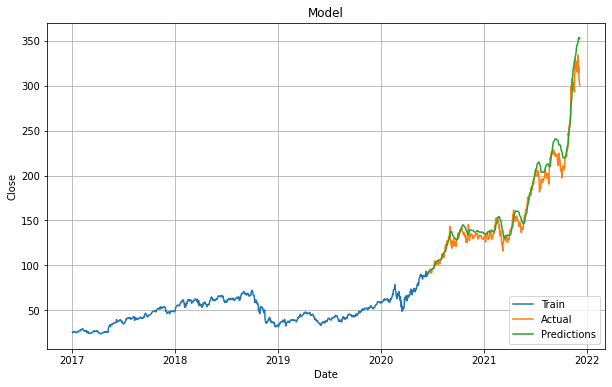

In [41]:
train = company[:training_data_len]
valid = company[training_data_len:]
 
valid['Predictions'] = predictions
plt.figure(figsize=(10,6)) 
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size = 10)
 
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.grid() 
plt.show()

The stocks predicted closing prices and the actual closing prices match fairly  closely.  

Show the stocks actual close prices and predicted close prices by date. 

In [42]:
# print actual close prices and predicted close prices. 
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2020-06-17,92.360001,92.542961
2020-06-18,92.180000,92.915527
2020-06-19,92.612503,93.294426
2020-06-22,95.267502,93.684341
2020-06-23,94.500000,94.301102
...,...,...
2021-11-30,326.760010,349.957428
2021-12-01,314.350006,352.437592
2021-12-02,321.260010,353.022766


Conclusions: The Long Short Term Memory (LSTM) model has an average prediction error of 10.65, which is very good. This means that the average dollar amount difference between the predicted closing price from the model and the actual closing price is $10.65. The stocks predicted closing prices and the actual closing prices are closely aligned with the predicted closing prices showing a high degree of accuracy. This model can be used to predict the stock prices of many other companies.

The models accuracy may be improved by tuning some of the models hyper parameters. 